# Amazon Product Recommendation System

## Complete Data Pipeline: Preprocessing + Exploration

This notebook contains the entire data pipeline in one place:

**Part 1: Preprocessing**
1. Environment Setup
2. Data Download
3. Data Loading
4. Preprocessing (Filter, Clean, Binarize)
5. Feature Encoding
6. Temporal Splitting
7. Save Processed Data

**Part 2: Exploration**
8. Basic Statistics
9. Interaction Distribution Analysis
10. Temporal Analysis
11. Brand and Category Analysis
12. Split Analysis
13. Summary

---
# Part 1: Preprocessing
---

## 1. Environment Setup

In [1]:
# Install required packages (uncomment if needed)
# !pip install torch pandas numpy scikit-learn tqdm matplotlib seaborn requests huggingface_hub

In [2]:
import os
import sys
import json
import gzip
import pickle
import platform
from pathlib import Path
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from tqdm.notebook import tqdm

# Set random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

%matplotlib inline

print("Imports successful")
print(f"Platform: {platform.system()} {platform.machine()}")

Imports successful
Platform: Darwin arm64


### Device Detection (GPU Support)

In [3]:
try:
    import torch
    
    def get_device(verbose=True):
        if torch.cuda.is_available():
            device = torch.device('cuda')
            if verbose:
                print(f"Using device: CUDA ({torch.cuda.get_device_name(0)})")
            return device
        
        if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
            device = torch.device('mps')
            if verbose:
                print(f"Using device: MPS (Apple Silicon)")
            return device
        
        device = torch.device('cpu')
        if verbose:
            print(f"Using device: CPU")
        return device
    
    device = get_device()
    
except ImportError:
    print("PyTorch not installed.")
    device = None

Using device: MPS (Apple Silicon)


### Configuration

In [4]:
# Configuration - MODIFY THIS SECTION AS NEEDED
CONFIG = {
    # Dataset category
    # Options: 'All_Beauty' (small/test), 'Electronics' (large), 'Clothing_Shoes_and_Jewelry'
    'category': 'All_Beauty',
    
    # Preprocessing parameters
    'min_user_interactions': 5,
    'min_item_interactions': 5,
    'binarize_ratings': True,
    
    # Paths
    'raw_data_dir': '../data/raw',
    'processed_data_dir': '../data/processed',
    'mappings_dir': '../data/mappings',
    
    # Features to encode
    'features_to_encode': ['user_id', 'item_id', 'brand', 'category'],
    
    'random_seed': 42
}

# Create directories
for dir_path in [CONFIG['raw_data_dir'], CONFIG['processed_data_dir'], CONFIG['mappings_dir']]:
    Path(dir_path).mkdir(parents=True, exist_ok=True)

print("Configuration:")
for key, value in CONFIG.items():
    if not key.endswith('_dir'):
        print(f"  {key}: {value}")

Configuration:
  category: All_Beauty
  min_user_interactions: 5
  min_item_interactions: 5
  binarize_ratings: True
  features_to_encode: ['user_id', 'item_id', 'brand', 'category']
  random_seed: 42


---
## 2. Data Download

In [5]:
from huggingface_hub import hf_hub_download
import shutil

def download_amazon_data(category, output_dir):
    """Download Amazon data using huggingface_hub."""
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    repo_id = "McAuley-Lab/Amazon-Reviews-2023"
    
    # Download reviews
    reviews_path = output_dir / f"{category}_reviews.jsonl"
    if not reviews_path.exists():
        print(f"Downloading {category} reviews...")
        try:
            downloaded_file = hf_hub_download(
                repo_id=repo_id,
                filename=f"raw/review_categories/{category}.jsonl",
                repo_type="dataset",
                local_dir=str(output_dir),
            )
            actual_path = output_dir / "raw" / "review_categories" / f"{category}.jsonl"
            if actual_path.exists():
                shutil.move(str(actual_path), str(reviews_path))
            print(f"Saved reviews to: {reviews_path}")
        except Exception as e:
            print(f"Error: {e}")
            print("Trying direct download...")
            url = f"https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/resolve/main/raw/review_categories/{category}.jsonl"
            download_with_progress(url, reviews_path)
    else:
        print(f"Reviews already exist: {reviews_path}")
    
    # Download metadata
    metadata_path = output_dir / f"{category}_metadata.jsonl"
    if not metadata_path.exists():
        print(f"Downloading {category} metadata...")
        try:
            downloaded_file = hf_hub_download(
                repo_id=repo_id,
                filename=f"raw/meta_categories/meta_{category}.jsonl",
                repo_type="dataset",
                local_dir=str(output_dir),
            )
            actual_path = output_dir / "raw" / "meta_categories" / f"meta_{category}.jsonl"
            if actual_path.exists():
                shutil.move(str(actual_path), str(metadata_path))
            print(f"Saved metadata to: {metadata_path}")
        except Exception as e:
            print(f"Error: {e}")
            print("Trying direct download...")
            url = f"https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/resolve/main/raw/meta_categories/meta_{category}.jsonl"
            download_with_progress(url, metadata_path)
    else:
        print(f"Metadata already exist: {metadata_path}")
    
    return {'reviews': str(reviews_path), 'metadata': str(metadata_path)}

def download_with_progress(url, output_path):
    """Download file with progress bar."""
    print(f"Downloading from: {url}")
    response = requests.get(url, stream=True)
    response.raise_for_status()
    
    total_size = int(response.headers.get('content-length', 0))
    
    with open(output_path, 'wb') as f:
        with tqdm(total=total_size, unit='iB', unit_scale=True) as pbar:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
                pbar.update(len(chunk))
    
    print(f"Downloaded to: {output_path}")

print("Download functions defined.")

Download functions defined.


In [6]:
# Download data
category = CONFIG['category']
raw_dir = Path(CONFIG['raw_data_dir'])

print(f"Downloading {category} dataset...")
print()

files = download_amazon_data(category, str(raw_dir))

reviews_jsonl = Path(files['reviews'])
metadata_jsonl = Path(files['metadata'])

print()
print("Data download complete!")
print(f"Reviews: {reviews_jsonl}")
print(f"Metadata: {metadata_jsonl}")


Reviews already exist: ../data/raw/All_Beauty_reviews.jsonl
Metadata already exist: ../data/raw/All_Beauty_metadata.jsonl

Data download complete!
Reviews: ../data/raw/All_Beauty_reviews.jsonl
Metadata: ../data/raw/All_Beauty_metadata.jsonl


---
## 3. Data Loading

In [7]:
def load_reviews(jsonl_path, max_lines=None):
    """Load reviews from JSONL file."""
    print(f"Loading reviews from: {jsonl_path}")
    
    reviews = []
    with open(jsonl_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(tqdm(f, desc="Loading reviews")):
            if max_lines and i >= max_lines:
                break
            
            try:
                review = json.loads(line.strip())
                reviews.append({
                    'user_id': review.get('user_id', ''),
                    'item_id': review.get('parent_asin', review.get('asin', '')),
                    'rating': review.get('rating', 0),
                    'timestamp': review.get('timestamp', 0),
                    'title': review.get('title', ''),
                    'text': review.get('text', '')
                })
            except (json.JSONDecodeError, KeyError):
                continue
    
    df = pd.DataFrame(reviews)
    print(f"Loaded {len(df):,} reviews")
    return df

def load_metadata(jsonl_path, max_lines=None):
    """Load product metadata from JSONL file."""
    print(f"Loading metadata from: {jsonl_path}")
    
    items = []
    with open(jsonl_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(tqdm(f, desc="Loading metadata")):
            if max_lines and i >= max_lines:
                break
            
            try:
                item = json.loads(line.strip())
                
                main_cat = item.get('main_category', 'unknown') or 'unknown'
                
                brand = item.get('store', '')
                if not brand:
                    details = item.get('details', {})
                    if isinstance(details, str):
                        try:
                            details = json.loads(details)
                        except:
                            details = {}
                    brand = details.get('Brand', 'unknown')
                if not brand:
                    brand = 'unknown'
                
                items.append({
                    'item_id': item.get('parent_asin', item.get('asin', '')),
                    'title': item.get('title', ''),
                    'brand': brand,
                    'category': main_cat
                })
            except (json.JSONDecodeError, KeyError):
                continue
    
    df = pd.DataFrame(items)
    print(f"Loaded {len(df):,} items")
    return df

In [8]:
# Load data
reviews_df = load_reviews(reviews_jsonl, max_lines=None)
metadata_df = load_metadata(metadata_jsonl, max_lines=None)

print(f"\nReviews shape: {reviews_df.shape}")
print(f"Metadata shape: {metadata_df.shape}")

Loading reviews from: ../data/raw/All_Beauty_reviews.jsonl


Loading reviews: 0it [00:00, ?it/s]

Loaded 701,528 reviews
Loading metadata from: ../data/raw/All_Beauty_metadata.jsonl


Loading metadata: 0it [00:00, ?it/s]

Loaded 112,590 items

Reviews shape: (701528, 6)
Metadata shape: (112590, 4)


In [9]:
# Preview data
print("Reviews Sample:")
display(reviews_df.head())

print("\nMetadata Sample:")
display(metadata_df.head())

Reviews Sample:


,user_id,item_id,rating,timestamp,title,text
0,AGKHLEW2SOWHNMFQIJGBECAF7INQ,B00YQ6X8EO,5.0,1588687728923,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...
1,AGKHLEW2SOWHNMFQIJGBECAF7INQ,B081TJ8YS3,4.0,1588615855070,Works great but smells a little weird.,"This product does what I need it to do, I just..."
2,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,B097R46CSY,5.0,1589665266052,Yes!,"Smells good, feels great!"
3,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,B09JS339BZ,1.0,1643393630220,Synthetic feeling,Felt synthetic
4,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,B08BZ63GMJ,5.0,1609322563534,A+,Love it



Metadata Sample:


,item_id,title,brand,category
0,B01CUPMQZE,"Howard LC0008 Leather Conditioner, 8-Ounce (4-...",Howard Products,All Beauty
1,B076WQZGPM,Yes to Tomatoes Detoxifying Charcoal Cleanser ...,Yes To,All Beauty
2,B000B658RI,Eye Patch Black Adult with Tie Band (6 Per Pack),Levine Health Products,All Beauty
3,B088FKY3VD,"Tattoo Eyebrow Stickers, Waterproof Eyebrow, 4...",Cherioll,All Beauty
4,B07NGFDN6G,Precision Plunger Bars for Cartridge Grips – 9...,Precision,All Beauty


---
## 4. Preprocessing

In [10]:
# Step 1: Filter invalid entries
print("Filtering invalid entries...")
initial_count = len(reviews_df)

reviews_df = reviews_df[
    (reviews_df['user_id'] != '') & 
    (reviews_df['item_id'] != '') &
    (reviews_df['timestamp'] > 0)
]

print(f"Removed {initial_count - len(reviews_df):,} invalid entries")
print(f"Remaining: {len(reviews_df):,} reviews")

Filtering invalid entries...
Removed 0 invalid entries
Remaining: 701,528 reviews


In [11]:
# Step 2: Iterative filtering
def filter_interactions(df, min_user_interactions=5, min_item_interactions=5, max_iterations=10):
    print(f"\nFiltering (min_user={min_user_interactions}, min_item={min_item_interactions})")
    print(f"Initial: {len(df):,} interactions, {df['user_id'].nunique():,} users, {df['item_id'].nunique():,} items")
    
    for iteration in range(max_iterations):
        initial_count = len(df)
        
        user_counts = df['user_id'].value_counts()
        valid_users = user_counts[user_counts >= min_user_interactions].index
        df = df[df['user_id'].isin(valid_users)]
        
        item_counts = df['item_id'].value_counts()
        valid_items = item_counts[item_counts >= min_item_interactions].index
        df = df[df['item_id'].isin(valid_items)]
        
        if len(df) == initial_count:
            print(f"Converged after {iteration + 1} iterations")
            break
    
    print(f"Final: {len(df):,} interactions, {df['user_id'].nunique():,} users, {df['item_id'].nunique():,} items")
    return df

reviews_df = filter_interactions(
    reviews_df,
    min_user_interactions=CONFIG['min_user_interactions'],
    min_item_interactions=CONFIG['min_item_interactions']
)


Filtering (min_user=5, min_item=5)
Initial: 701,528 interactions, 631,986 users, 112,565 items
Final: 3,315 interactions, 357 users, 479 items


In [12]:
# Step 3: Binarize ratings
if CONFIG['binarize_ratings']:
    reviews_df['feedback'] = 1
    print("Binarized all interactions as positive feedback")
else:
    reviews_df['feedback'] = reviews_df['rating']
    print("Kept original ratings")

Binarized all interactions as positive feedback


In [13]:
# Step 4: Merge with metadata
print("Merging with metadata...")

metadata_subset = metadata_df[['item_id', 'brand', 'category']].drop_duplicates()
merged_df = reviews_df.merge(metadata_subset, on='item_id', how='left')

merged_df['brand'] = merged_df['brand'].fillna('unknown')
merged_df['category'] = merged_df['category'].fillna('unknown')

print(f"Merged: {len(merged_df):,} interactions")

Merging with metadata...
Merged: 3,315 interactions


In [14]:
# Step 5: Sort by timestamp
merged_df = merged_df.sort_values(['user_id', 'timestamp']).reset_index(drop=True)
print("Sorted by user and timestamp")

Sorted by user and timestamp


---
## 5. Feature Encoding

In [15]:
class FeatureEncoder:
    """Encode categorical features to contiguous integers."""
    
    def __init__(self):
        self.encoders = {}
        self.inverse_encoders = {}
        self.vocab_sizes = {}
    
    def fit(self, df, features):
        print("\nFitting encoders...")
        for feature in features:
            if feature not in df.columns:
                continue
            unique_values = df[feature].unique()
            encoder = {val: idx for idx, val in enumerate(sorted(unique_values, key=str))}
            self.encoders[feature] = encoder
            self.inverse_encoders[feature] = {idx: val for val, idx in encoder.items()}
            self.vocab_sizes[feature] = len(encoder)
            print(f"{feature}: {len(encoder):,} unique values")
        return self
    
    def transform(self, df, features=None):
        if features is None:
            features = list(self.encoders.keys())
        df_transformed = df.copy()
        for feature in features:
            if feature in self.encoders:
                df_transformed[f"{feature}_encoded"] = df_transformed[feature].map(self.encoders[feature]).fillna(-1).astype(int)
        return df_transformed
    
    def fit_transform(self, df, features):
        self.fit(df, features)
        return self.transform(df, features)
    
    def save(self, output_dir):
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
        for feature in self.encoders:
            with open(output_dir / f"{feature}_encoder.pkl", 'wb') as f:
                pickle.dump({'encoder': self.encoders[feature], 'inverse_encoder': self.inverse_encoders[feature], 'vocab_size': self.vocab_sizes[feature]}, f)
        with open(output_dir / "vocab_sizes.pkl", 'wb') as f:
            pickle.dump(self.vocab_sizes, f)
        print("Saved encoders")

In [16]:
encoder = FeatureEncoder()
encoded_df = encoder.fit_transform(merged_df, CONFIG['features_to_encode'])

print("\nVocabulary Sizes:")
for feature, size in encoder.vocab_sizes.items():
    print(f"  {feature}: {size:,}")


Fitting encoders...
user_id: 357 unique values
item_id: 479 unique values
brand: 401 unique values
category: 2 unique values

Vocabulary Sizes:
  user_id: 357
  item_id: 479
  brand: 401
  category: 2


---
## 6. Temporal Splitting

In [17]:
def temporal_split_leave_one_out(df, user_col='user_id_encoded', time_col='timestamp'):
    print("\nPerforming temporal split (leave-one-out)...")
    
    df = df.sort_values([user_col, time_col]).reset_index(drop=True)
    
    train_indices, val_indices, test_indices = [], [], []
    
    for user_id, group in df.groupby(user_col):
        indices = group.index.tolist()
        n = len(indices)
        
        if n >= 3:
            train_indices.extend(indices[:-2])
            val_indices.append(indices[-2])
            test_indices.append(indices[-1])
        elif n == 2:
            train_indices.append(indices[0])
            test_indices.append(indices[1])
        elif n == 1:
            train_indices.append(indices[0])
    
    train_df = df.loc[train_indices].reset_index(drop=True)
    val_df = df.loc[val_indices].reset_index(drop=True)
    test_df = df.loc[test_indices].reset_index(drop=True)
    
    print(f"Train: {len(train_df):,} ({len(train_df)/len(df)*100:.1f}%)")
    print(f"Validation: {len(val_df):,} ({len(val_df)/len(df)*100:.1f}%)")
    print(f"Test: {len(test_df):,} ({len(test_df)/len(df)*100:.1f}%)")
    
    return train_df, val_df, test_df

train_df, val_df, test_df = temporal_split_leave_one_out(encoded_df)


Performing temporal split (leave-one-out)...
Train: 2,601 (78.5%)
Validation: 357 (10.8%)
Test: 357 (10.8%)


---
## 7. Save Processed Data

In [18]:
# Save splits
processed_dir = Path(CONFIG['processed_data_dir'])

train_df.to_csv(processed_dir / 'train.csv', index=False)
val_df.to_csv(processed_dir / 'validation.csv', index=False)
test_df.to_csv(processed_dir / 'test.csv', index=False)

train_df.to_pickle(processed_dir / 'train.pkl')
val_df.to_pickle(processed_dir / 'validation.pkl')
test_df.to_pickle(processed_dir / 'test.pkl')

print("Saved train/val/test splits (CSV and pickle)")

# Save encoders
encoder.save(CONFIG['mappings_dir'])

Saved train/val/test splits (CSV and pickle)
Saved encoders


---
# Part 2: Data Exploration
---

## 8. Basic Statistics

In [19]:
# Combine all splits for overall statistics
all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

print("="*50)
print("Dataset Statistics:")
print("="*50)
print(f"Total interactions: {len(all_df):,}")
print(f"Unique users: {all_df['user_id_encoded'].nunique():,}")
print(f"Unique items: {all_df['item_id_encoded'].nunique():,}")
print(f"Unique brands: {all_df['brand_encoded'].nunique():,}")
print(f"Unique categories: {all_df['category_encoded'].nunique():,}")

n_users = all_df['user_id_encoded'].nunique()
n_items = all_df['item_id_encoded'].nunique()
sparsity = 1 - len(all_df) / (n_users * n_items)
print(f"\nSparsity: {sparsity:.6f} ({sparsity*100:.4f}%)")

Dataset Statistics:
Total interactions: 3,315
Unique users: 357
Unique items: 479
Unique brands: 401
Unique categories: 2

Sparsity: 0.980614 (98.0614%)


## 9. Interaction Distribution Analysis

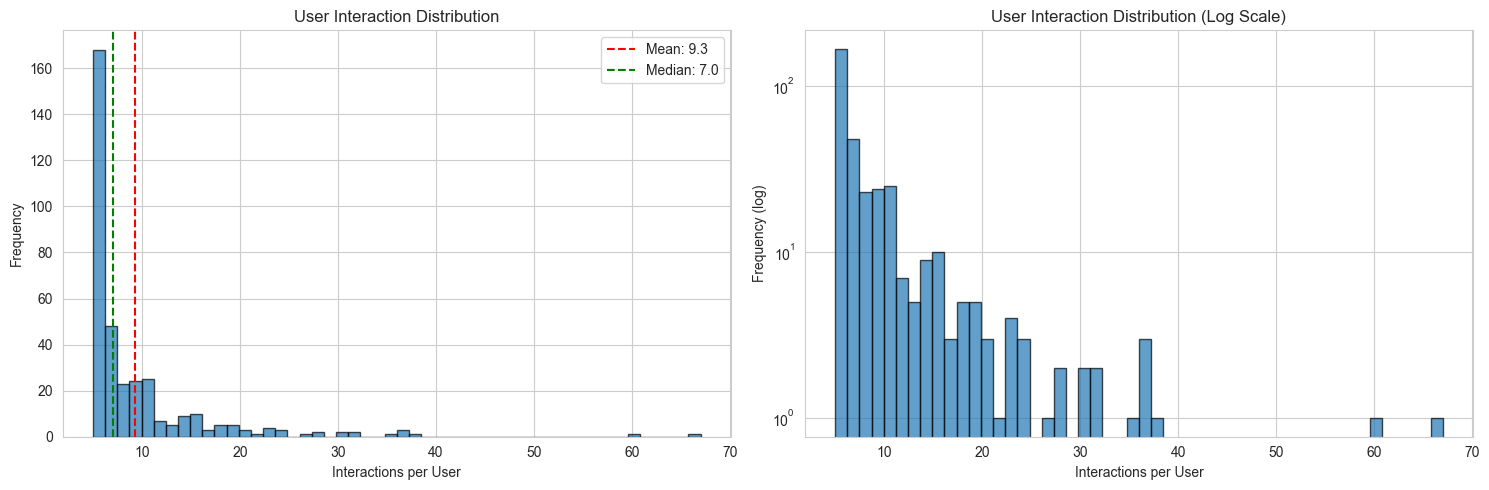

User Stats: Mean=9.29, Median=7.00, Min=5, Max=67


In [20]:
# User interaction distribution
user_interactions = all_df['user_id_encoded'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(user_interactions, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Interactions per User')
axes[0].set_ylabel('Frequency')
axes[0].set_title('User Interaction Distribution')
axes[0].axvline(user_interactions.mean(), color='red', linestyle='--', label=f'Mean: {user_interactions.mean():.1f}')
axes[0].axvline(user_interactions.median(), color='green', linestyle='--', label=f'Median: {user_interactions.median():.1f}')
axes[0].legend()

axes[1].hist(user_interactions, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Interactions per User')
axes[1].set_ylabel('Frequency (log)')
axes[1].set_title('User Interaction Distribution (Log Scale)')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

print(f"User Stats: Mean={user_interactions.mean():.2f}, Median={user_interactions.median():.2f}, Min={user_interactions.min()}, Max={user_interactions.max()}")

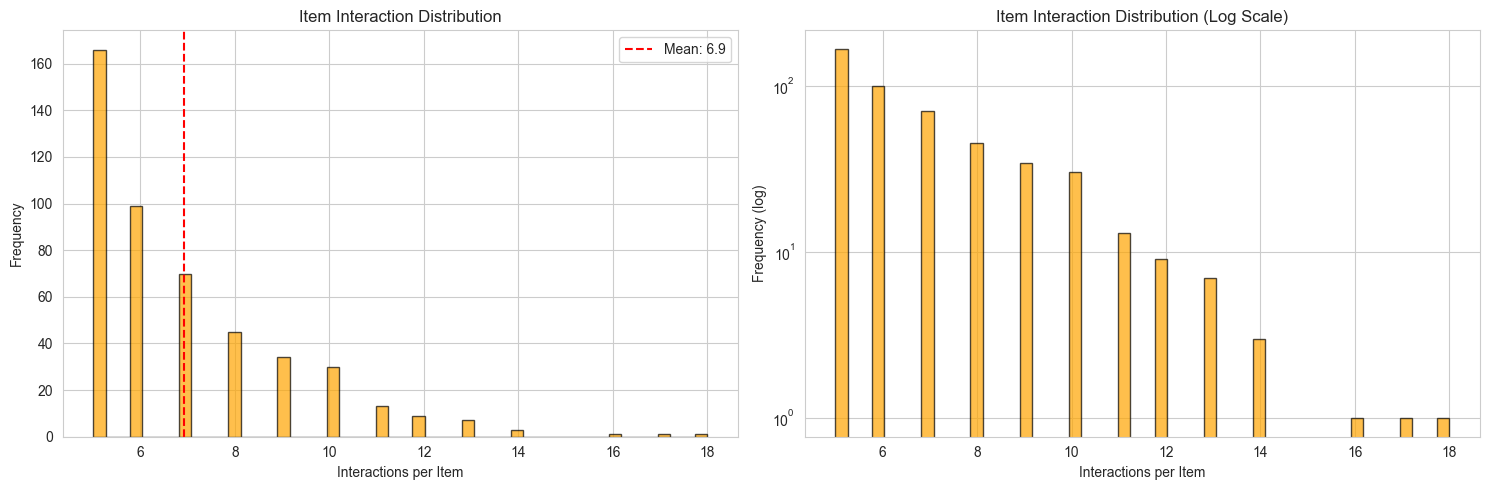

Item Stats: Mean=6.92, Median=6.00, Min=5, Max=18


In [21]:
# Item interaction distribution
item_interactions = all_df['item_id_encoded'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(item_interactions, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0].set_xlabel('Interactions per Item')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Item Interaction Distribution')
axes[0].axvline(item_interactions.mean(), color='red', linestyle='--', label=f'Mean: {item_interactions.mean():.1f}')
axes[0].legend()

axes[1].hist(item_interactions, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Interactions per Item')
axes[1].set_ylabel('Frequency (log)')
axes[1].set_title('Item Interaction Distribution (Log Scale)')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

print(f"Item Stats: Mean={item_interactions.mean():.2f}, Median={item_interactions.median():.2f}, Min={item_interactions.min()}, Max={item_interactions.max()}")

## 10. Temporal Analysis

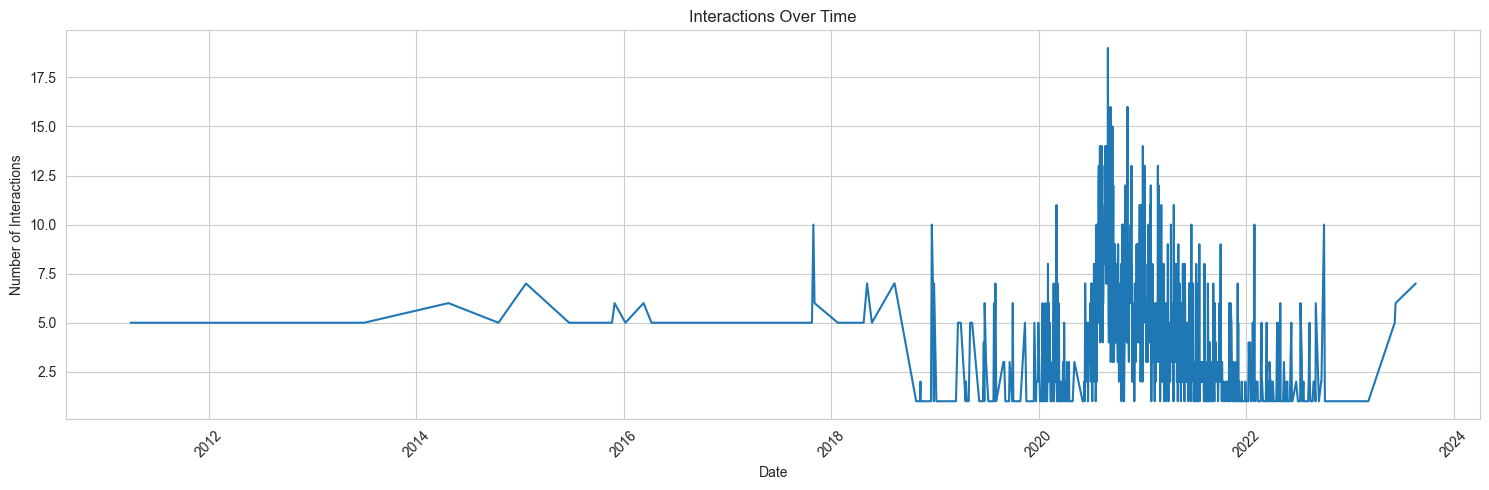

Date range: 2011-04-01 23:46:06 to 2023-08-21 01:42:39.574000


In [22]:
# Convert timestamp to datetime
all_df['datetime'] = pd.to_datetime(all_df['timestamp'], unit='ms')

# Interactions over time
daily_interactions = all_df.groupby(all_df['datetime'].dt.date).size()

plt.figure(figsize=(15, 5))
plt.plot(daily_interactions.index, daily_interactions.values)
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.title('Interactions Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Date range: {all_df['datetime'].min()} to {all_df['datetime'].max()}")

## 11. Brand and Category Analysis

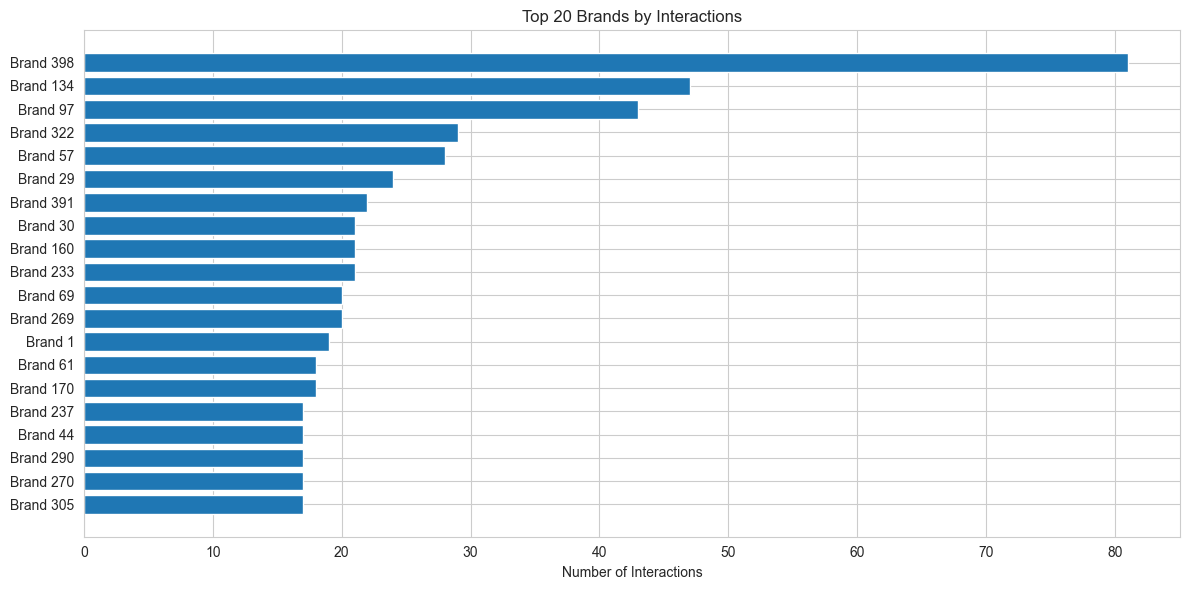

In [23]:
# Top brands
top_brands = all_df['brand_encoded'].value_counts().head(20)

plt.figure(figsize=(12, 6))
plt.barh(range(len(top_brands)), top_brands.values)
plt.yticks(range(len(top_brands)), [f"Brand {i}" for i in top_brands.index])
plt.xlabel('Number of Interactions')
plt.title('Top 20 Brands by Interactions')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

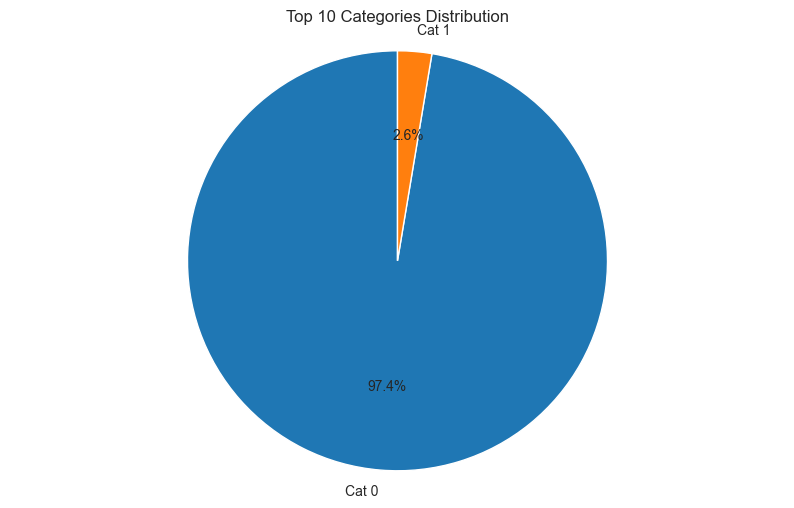

In [24]:
# Category distribution
category_dist = all_df['category_encoded'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(category_dist.head(10), labels=[f"Cat {i}" for i in category_dist.head(10).index],
        autopct='%1.1f%%', startangle=90)
plt.title('Top 10 Categories Distribution')
plt.axis('equal')
plt.show()

## 12. Split Analysis

Split Comparison:
              Train  Validation  Test
Interactions   2601         357   357
Users           357         357   357
Items           470         262   233


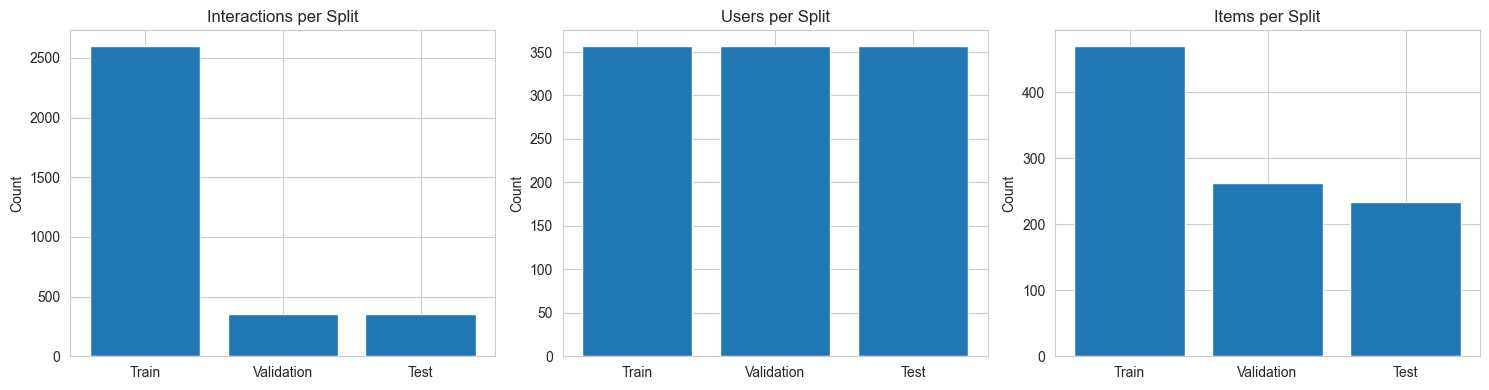

In [25]:
# Compare splits
split_stats = pd.DataFrame({
    'Train': [len(train_df), train_df['user_id_encoded'].nunique(), train_df['item_id_encoded'].nunique()],
    'Validation': [len(val_df), val_df['user_id_encoded'].nunique(), val_df['item_id_encoded'].nunique()],
    'Test': [len(test_df), test_df['user_id_encoded'].nunique(), test_df['item_id_encoded'].nunique()]
}, index=['Interactions', 'Users', 'Items'])

print("Split Comparison:")
print(split_stats)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, metric in enumerate(['Interactions', 'Users', 'Items']):
    axes[idx].bar(split_stats.columns, split_stats.loc[metric])
    axes[idx].set_ylabel('Count')
    axes[idx].set_title(f'{metric} per Split')

plt.tight_layout()
plt.show()

---
## 13. Summary

In [26]:
print("="*70)
print("PIPELINE COMPLETE!")
print("="*70)

print(f"\nDataset: {CONFIG['category']}")
print(f"\nStatistics:")
print(f"  Total interactions: {len(all_df):,}")
print(f"  Users: {n_users:,}")
print(f"  Items: {n_items:,}")
print(f"  Sparsity: {sparsity*100:.4f}%")

print(f"\nSplits:")
print(f"  Train: {len(train_df):,}")
print(f"  Validation: {len(val_df):,}")
print(f"  Test: {len(test_df):,}")

print(f"\nOutput Files:")
print(f"  Data: {CONFIG['processed_data_dir']}")
print(f"  Encoders: {CONFIG['mappings_dir']}")

print(f"\nKey Findings:")
print(f"  - Avg interactions per user: {user_interactions.mean():.1f}")
print(f"  - Avg interactions per item: {item_interactions.mean():.1f}")
print(f"  - Power-law distribution in user/item interactions")

print("\n" + "="*70)
print("Ready for Phase 2: Model Implementation")
print("="*70)

PIPELINE COMPLETE!

Dataset: All_Beauty

Statistics:
  Total interactions: 3,315
  Users: 357
  Items: 479
  Sparsity: 98.0614%

Splits:
  Train: 2,601
  Validation: 357
  Test: 357

Output Files:
  Data: ../data/processed
  Encoders: ../data/mappings

Key Findings:
  - Avg interactions per user: 9.3
  - Avg interactions per item: 6.9
  - Power-law distribution in user/item interactions

Ready for Phase 2: Model Implementation


---
# Part 3: Model-Specific Data Structures

This section creates the data structures required for different model architectures:
- **User-Item Interaction Matrix** - For Matrix Factorization
- **Sequential Data Format** - For LSTM/Transformer models
- **Bipartite Graph Structure** - For Graph Neural Networks (LightGCN)

## 14. User-Item Interaction Matrix (for Matrix Factorization)

In [27]:
import scipy.sparse as sp
import numpy as np

def create_interaction_matrix(df, n_users, n_items, user_col='user_id_encoded', item_col='item_id_encoded'):
    """
    Create a sparse user-item interaction matrix.
    
    Args:
        df: DataFrame with user-item interactions
        n_users: Total number of users
        n_items: Total number of items
        
    Returns:
        Sparse CSR matrix of shape (n_users, n_items)
    """
    rows = df[user_col].values
    cols = df[item_col].values
    data = np.ones(len(df))  # Binary interactions (1 = interacted)
    
    matrix = sp.csr_matrix((data, (rows, cols)), shape=(n_users, n_items))
    return matrix

# Get dimensions from encoder
n_users = encoder.vocab_sizes['user_id']
n_items = encoder.vocab_sizes['item_id']

print(f"Creating interaction matrix of size: {n_users} users x {n_items} items")

# Create matrices for each split
train_matrix = create_interaction_matrix(train_df, n_users, n_items)
val_matrix = create_interaction_matrix(val_df, n_users, n_items)
test_matrix = create_interaction_matrix(test_df, n_users, n_items)

# Combined training matrix (train + val for final training)
train_val_matrix = train_matrix + val_matrix
train_val_matrix.data = np.clip(train_val_matrix.data, 0, 1)  # Ensure binary

print(f"\nMatrix Statistics:")
print(f"  Train matrix: {train_matrix.nnz:,} interactions")
print(f"  Validation matrix: {val_matrix.nnz:,} interactions")
print(f"  Test matrix: {test_matrix.nnz:,} interactions")
print(f"  Sparsity: {(1 - train_matrix.nnz / (n_users * n_items)) * 100:.4f}%")

Creating interaction matrix of size: 357 users x 479 items

Matrix Statistics:
  Train matrix: 2,315 interactions
  Validation matrix: 357 interactions
  Test matrix: 357 interactions
  Sparsity: 98.6462%


In [28]:
# Save interaction matrices
sp.save_npz(os.path.join(CONFIG['processed_data_dir'], 'train_matrix.npz'), train_matrix)
sp.save_npz(os.path.join(CONFIG['processed_data_dir'], 'val_matrix.npz'), val_matrix)
sp.save_npz(os.path.join(CONFIG['processed_data_dir'], 'test_matrix.npz'), test_matrix)
sp.save_npz(os.path.join(CONFIG['processed_data_dir'], 'train_val_matrix.npz'), train_val_matrix)

print("Interaction matrices saved!")

Interaction matrices saved!


## 15. Sequential Data Format (for LSTM/Transformer)

In [29]:
def create_user_sequences(df, user_col='user_id_encoded', item_col='item_id_encoded', 
                          time_col='timestamp', max_seq_len=50):
    """
    Create item sequences for each user, ordered by timestamp.
    
    Args:
        df: DataFrame with user-item interactions
        max_seq_len: Maximum sequence length (truncate from left if longer)
        
    Returns:
        Dictionary mapping user_id to list of item_ids in chronological order
    """
    # Sort by user and timestamp
    df_sorted = df.sort_values([user_col, time_col])
    
    # Group by user and collect item sequences
    sequences = {}
    for user_id, group in df_sorted.groupby(user_col):
        items = group[item_col].tolist()
        # Truncate from left (keep most recent) if too long
        if len(items) > max_seq_len:
            items = items[-max_seq_len:]
        sequences[user_id] = items
    
    return sequences

# Create sequences from training data
MAX_SEQ_LEN = 50
user_sequences = create_user_sequences(train_df, max_seq_len=MAX_SEQ_LEN)

# Statistics
seq_lengths = [len(seq) for seq in user_sequences.values()]
print(f"User Sequences Created:")
print(f"  Number of users: {len(user_sequences):,}")
print(f"  Max sequence length: {MAX_SEQ_LEN}")
print(f"  Avg sequence length: {np.mean(seq_lengths):.2f}")
print(f"  Min sequence length: {min(seq_lengths)}")
print(f"  Max actual length: {max(seq_lengths)}")

User Sequences Created:
  Number of users: 357
  Max sequence length: 50
  Avg sequence length: 7.22
  Min sequence length: 3
  Max actual length: 50


In [30]:
import pickle

# Create validation and test targets (the held-out items)
val_targets = val_df.groupby('user_id_encoded')['item_id_encoded'].first().to_dict()
test_targets = test_df.groupby('user_id_encoded')['item_id_encoded'].first().to_dict()

# Save sequences
sequence_data = {
    'user_sequences': user_sequences,
    'val_targets': val_targets,
    'test_targets': test_targets,
    'max_seq_len': MAX_SEQ_LEN,
    'n_users': n_users,
    'n_items': n_items
}

with open(os.path.join(CONFIG['processed_data_dir'], 'sequences.pkl'), 'wb') as f:
    pickle.dump(sequence_data, f)

print("Sequential data saved!")
print(f"  Validation targets: {len(val_targets):,} users")
print(f"  Test targets: {len(test_targets):,} users")

Sequential data saved!
  Validation targets: 357 users
  Test targets: 357 users


## 16. Bipartite Graph Structure (for LightGCN)

In [31]:
def create_bipartite_graph_edges(df, n_users, user_col='user_id_encoded', item_col='item_id_encoded'):
    """
    Create edge index for a user-item bipartite graph.
    Items are offset by n_users to create a unified node space.
    
    Node IDs:
        - Users: 0 to n_users-1
        - Items: n_users to n_users+n_items-1
    
    Args:
        df: DataFrame with user-item interactions
        n_users: Number of users (used as offset for item IDs)
        
    Returns:
        edge_index: numpy array of shape (2, num_edges) for user->item edges
    """
    users = df[user_col].values
    items = df[item_col].values + n_users  # Offset items
    
    # Create bidirectional edges (user->item and item->user)
    edge_index = np.array([
        np.concatenate([users, items]),
        np.concatenate([items, users])
    ])
    
    return edge_index

# Create graph from training data
train_edge_index = create_bipartite_graph_edges(train_df, n_users)

print(f"Bipartite Graph Created:")
print(f"  Total nodes: {n_users + n_items:,} (users: {n_users:,}, items: {n_items:,})")
print(f"  Total edges: {train_edge_index.shape[1]:,} (bidirectional)")
print(f"  Edges per interaction: 2 (user->item + item->user)")

Bipartite Graph Created:
  Total nodes: 836 (users: 357, items: 479)
  Total edges: 5,202 (bidirectional)
  Edges per interaction: 2 (user->item + item->user)


In [32]:
# Save graph structure
graph_data = {
    'edge_index': train_edge_index,
    'n_users': n_users,
    'n_items': n_items,
    'n_nodes': n_users + n_items
}

with open(os.path.join(CONFIG['processed_data_dir'], 'graph.pkl'), 'wb') as f:
    pickle.dump(graph_data, f)

# Also save edge index as numpy for PyTorch Geometric
np.save(os.path.join(CONFIG['processed_data_dir'], 'edge_index.npy'), train_edge_index)

print("Graph structure saved!")

Graph structure saved!


---
## 17. Final Data Summary

In [33]:
print("="*70)
print("DATA PREPARATION COMPLETE!")
print("="*70)

print(f"\n{'='*70}")
print("FILES SAVED:")
print("="*70)

import os
saved_files = os.listdir(CONFIG['processed_data_dir'])
for f in sorted(saved_files):
    if f != '.gitkeep':
        size = os.path.getsize(os.path.join(CONFIG['processed_data_dir'], f))
        print(f"  {f}: {size/1024:.1f} KB")

print(f"\n{'='*70}")
print("DATA STRUCTURES READY FOR:")
print("="*70)
print("  ✓ Matrix Factorization: train_matrix.npz, val_matrix.npz, test_matrix.npz")
print("  ✓ LSTM/Transformer: sequences.pkl")
print("  ✓ LightGCN: graph.pkl, edge_index.npy")

DATA PREPARATION COMPLETE!

FILES SAVED:
  edge_index.npy: 81.4 KB
  graph.pkl: 81.5 KB
  sequences.pkl: 11.8 KB
  test.csv: 202.9 KB
  test.pkl: 214.1 KB
  test_matrix.npz: 2.2 KB
  train.csv: 1662.3 KB
  train.pkl: 1721.1 KB
  train_matrix.npz: 5.6 KB
  train_val_matrix.npz: 5.8 KB
  val_matrix.npz: 2.2 KB
  validation.csv: 205.4 KB
  validation.pkl: 217.2 KB

DATA STRUCTURES READY FOR:
  ✓ Matrix Factorization: train_matrix.npz, val_matrix.npz, test_matrix.npz
  ✓ LSTM/Transformer: sequences.pkl
  ✓ LightGCN: graph.pkl, edge_index.npy
